<a href="https://colab.research.google.com/github/khanmhmdi/Saliency-guided-training/blob/main/Slaiency_guided_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 64
epochs = 1
lr = 0.01
lambda_ = 1.0   # weight for KL divergence loss
gamma = 0.1     # weight for TV regularization on fθ(X̃)
k = 50          # number of pixels (features) to mask per image

# MNIST data loaders
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Fully Convolutional Network for MNIST:
# This network produces a spatial output (logit map) from which we also compute the final classification by average pooling.
class FCN_MNIST(nn.Module):
    def __init__(self):
        super(FCN_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # [B, 32, 28, 28]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # [B, 64, 28, 28]
        self.pool  = nn.MaxPool2d(2, 2)                           # halves spatial dims
        # Final 1x1 convolution to produce class logits for each spatial location.
        self.conv3 = nn.Conv2d(64, 10, kernel_size=3, padding=1) # [B, 10, H, W]

    def forward(self, x, return_spatial=False):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # 28->14
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # 14->7; now x has shape [B, 64, 7, 7]
        spatial_out = self.conv3(x)  # [B, 10, 7, 7]
        # Aggregate spatially to produce a 10-dim vector for classification:
        logits = spatial_out.mean(dim=(2, 3))
        if return_spatial:
            return logits, spatial_out
        else:
            return logits

# TV loss on a spatial tensor.
def tv_loss_output(output):
    # Crop the output so that we can compute differences on the same positions.
    f = output[:, :, :-1, :-1]
    diff_x = output[:, :, 1:, :-1] - f   # vertical differences
    diff_y = output[:, :, :-1, 1:] - f   # horizontal differences
    tv = torch.sqrt(diff_x.pow(2) + diff_y.pow(2) + 1e-6).sum()
    return tv

# Compute saliency map as before.
def compute_saliency(model, inputs, labels):
    inputs.requires_grad_()
    outputs = model(inputs)
    scores = outputs.gather(1, labels.unsqueeze(1)).squeeze()
    saliency = torch.autograd.grad(scores.sum(), inputs, create_graph=True)[0]
    return saliency

# Mask the k low-saliency pixels.
def mask_low_saliency_features(inputs, saliency, k):
    batch_size, channels, H, W = saliency.size()
    saliency_flat = saliency.abs().view(batch_size, -1)
    _, indices = saliency_flat.topk(k, largest=False)
    mask = torch.ones_like(saliency_flat)
    for i in range(batch_size):
        mask[i].scatter_(0, indices[i], 0)
    mask = mask.view(batch_size, channels, H, W)
    masked_inputs = inputs * mask
    return masked_inputs

# KL divergence between two distributions.
def kl_divergence(original_logits, masked_logits):
    original_log_probs = F.log_softmax(original_logits, dim=1)
    masked_probs = F.softmax(masked_logits, dim=1)
    kl = F.kl_div(original_log_probs, masked_probs, reduction='batchmean')
    return kl

# Training loop that uses TV loss on fθ(X̃) (i.e. on the spatial output of the FCN).
def train_model(model, train_loader, optimizer, device, use_tv=False):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Forward pass on original input (classification output only)
            outputs = model(data)
            loss_class = F.cross_entropy(outputs, target)

            # Compute saliency on original input (if used for masking)
            saliency = compute_saliency(model, data, target)
            masked_data = mask_low_saliency_features(data, saliency, k)

            # Forward pass on masked input, returning spatial output for TV loss.
            outputs_masked, spatial_masked = model(masked_data, return_spatial=True)

            loss_kl = kl_divergence(outputs, outputs_masked)

            loss = loss_class + lambda_ * loss_kl
            if use_tv:
                loss_tv = tv_loss_output(spatial_masked)
                loss = loss + gamma * loss_tv

            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1} Batch {batch_idx}: Loss = {loss.item():.4f}")
    return model

# Evaluation function.
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            pred = outputs.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += data.size(0)
    accuracy = 100. * correct / total
    return accuracy


# Visualization functions.
def visualize_saliency(model, data, target, k, title_prefix=""):
    model.eval()
    data.requires_grad_()

    outputs = model(data)
    scores = outputs.gather(1, target.unsqueeze(1)).squeeze()
    saliency = torch.autograd.grad(scores.sum(), data, retain_graph=True)[0]

    saliency_abs = saliency.abs().detach().cpu().numpy()
    masked_data = mask_low_saliency_features(data, saliency, k)
    masked_data_np = masked_data.detach().cpu().numpy()
    original_images = data.detach().cpu().numpy()

    num_images = 5
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    for i in range(num_images):
        axs[i].imshow(masked_data_np[i][0], cmap='gray')
        axs[i].set_title(f"{title_prefix}Masked")
        axs[i].axis('off')
    plt.suptitle(f"{title_prefix} Model - Masked Inputs", fontsize=14)
    plt.show()

    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    for i in range(num_images):
        axs[i].imshow(saliency_abs[i][0], cmap='hot')
        axs[i].set_title(f"{title_prefix}Saliency")
        axs[i].axis('off')
    plt.suptitle(f"{title_prefix} Model - Saliency Maps", fontsize=14)
    plt.show()

    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    for i in range(num_images):
        axs[i].imshow(original_images[i][0], cmap='gray')
        axs[i].set_title("Original")
        axs[i].axis('off')
    plt.suptitle("Original Images", fontsize=14)
    plt.show()

def compare_saliency_visualizations(model_simple, model_tv, data, target, k):
    model_simple.eval()
    model_tv.eval()
    data.requires_grad_()

    outputs_simple = model_simple(data)
    scores_simple = outputs_simple.gather(1, target.unsqueeze(1)).squeeze()
    saliency_simple = torch.autograd.grad(scores_simple.sum(), data, retain_graph=True)[0]
    masked_simple = mask_low_saliency_features(data, saliency_simple, k)

    outputs_tv = model_tv(data)
    scores_tv = outputs_tv.gather(1, target.unsqueeze(1)).squeeze()
    saliency_tv = torch.autograd.grad(scores_tv.sum(), data, retain_graph=True)[0]
    masked_tv = mask_low_saliency_features(data, saliency_tv, k)

    original_images = data.detach().cpu().numpy()
    saliency_simple_abs = saliency_simple.abs().detach().cpu().numpy()
    masked_simple_np = masked_simple.detach().cpu().numpy()
    saliency_tv_abs = saliency_tv.abs().detach().cpu().numpy()
    masked_tv_np = masked_tv.detach().cpu().numpy()

    num_images = 5
    fig, axs = plt.subplots(5, num_images, figsize=(num_images * 3, 15))
    for i in range(num_images):
        axs[0, i].imshow(original_images[i][0], cmap='gray')
        axs[0, i].set_title("Original")
        axs[0, i].axis('off')

        axs[1, i].imshow(saliency_simple_abs[i][0], cmap='hot')
        axs[1, i].set_title("Simple Saliency")
        axs[1, i].axis('off')

        axs[2, i].imshow(masked_simple_np[i][0], cmap='gray')
        axs[2, i].set_title("Simple Masked")
        axs[2, i].axis('off')

        axs[3, i].imshow(saliency_tv_abs[i][0], cmap='hot')
        axs[3, i].set_title("TV Saliency")
        axs[3, i].axis('off')

        axs[4, i].imshow(masked_tv_np[i][0], cmap='gray')
        axs[4, i].set_title("TV Masked")
        axs[4, i].axis('off')

    plt.suptitle("Comparison of Saliency and Masked Inputs", fontsize=16)
    plt.tight_layout()
    plt.show()

# Set up device and initialize two models.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_simple = FCN_MNIST().to(device)
model_tv     = FCN_MNIST().to(device)

optimizer_simple = optim.SGD(model_simple.parameters(), lr=lr)
optimizer_tv     = optim.SGD(model_tv.parameters(), lr=lr)

print("Training Simple Saliency Guided Training (without TV)...")
train_model(model_simple, train_loader, optimizer_simple, device, use_tv=False)
acc_simple = evaluate(model_simple, test_loader, device)
print(f"Test Accuracy (Simple Saliency Guided): {acc_simple:.2f}%\n")

print("Training Saliency Guided Training with TV Regularization on fθ(X̃)...")
train_model(model_tv, train_loader, optimizer_tv, device, use_tv=True)
acc_tv = evaluate(model_tv, test_loader, device)
print(f"Test Accuracy (Saliency Guided with TV): {acc_tv:.2f}%")


# Visualization
data_vis, target_vis = next(iter(test_loader))
data_vis, target_vis = data_vis.to(device), target_vis.to(device)

print("Visualizing Simple Saliency Guided Training:")
visualize_saliency(model_simple, data_vis, target_vis, k, title_prefix="Simple ")

print("Visualizing Saliency Guided Training with TV Regularization:")
visualize_saliency(model_tv, data_vis, target_vis, k, title_prefix="TV ")

print("Comparing Both Models:")
compare_saliency_visualizations(model_simple, model_tv, data_vis, target_vis, k)


Training Simple Saliency Guided Training (without TV)...
Epoch 1 Batch 0: Loss = 2.3040
Epoch 1 Batch 100: Loss = 2.3004
Epoch 1 Batch 200: Loss = 2.2926
Epoch 1 Batch 300: Loss = 2.2836
Epoch 1 Batch 400: Loss = 2.2769
Epoch 1 Batch 500: Loss = 2.2666
Epoch 1 Batch 600: Loss = 2.2604
Epoch 1 Batch 700: Loss = 2.2608
Epoch 1 Batch 800: Loss = 2.2063
Epoch 1 Batch 900: Loss = 2.1820
Test Accuracy (Simple Saliency Guided): 22.95%

Training Saliency Guided Training with TV Regularization on fθ(X̃)...
Epoch 1 Batch 0: Loss = 115.8403
Epoch 1 Batch 100: Loss = nan
Epoch 1 Batch 200: Loss = nan
Epoch 1 Batch 300: Loss = nan
Epoch 1 Batch 400: Loss = nan
Epoch 1 Batch 500: Loss = nan
Epoch 1 Batch 600: Loss = nan
Epoch 1 Batch 700: Loss = nan
Epoch 1 Batch 800: Loss = nan


KeyboardInterrupt: 

Training Simple SGT...
Epoch 1: Loss=0.2281, Acc=0.9329
Epoch 2: Loss=0.0796, Acc=0.9766
Epoch 3: Loss=0.0607, Acc=0.9826
Epoch 4: Loss=0.0512, Acc=0.9852
Epoch 5: Loss=0.0460, Acc=0.9863
Epoch 6: Loss=0.0402, Acc=0.9882
Epoch 7: Loss=0.0380, Acc=0.9887
Epoch 8: Loss=0.0346, Acc=0.9895
Epoch 9: Loss=0.0321, Acc=0.9902
Epoch 10: Loss=0.0288, Acc=0.9917
Training TV Regularized...
Epoch 1: Loss=7.5124, Acc=0.9374
Epoch 2: Loss=7.3609, Acc=0.9796
Epoch 3: Loss=7.3456, Acc=0.9838
Epoch 4: Loss=7.3357, Acc=0.9863
Epoch 5: Loss=7.3316, Acc=0.9879
Epoch 6: Loss=7.3260, Acc=0.9892
Epoch 7: Loss=7.3234, Acc=0.9899
Epoch 8: Loss=7.3208, Acc=0.9910
Epoch 9: Loss=7.3180, Acc=0.9916
Epoch 10: Loss=7.3158, Acc=0.9923


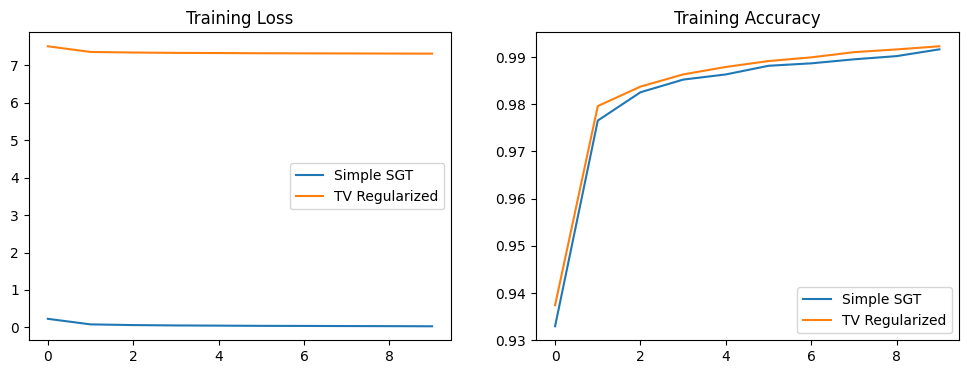

Simple SGT Saliency:


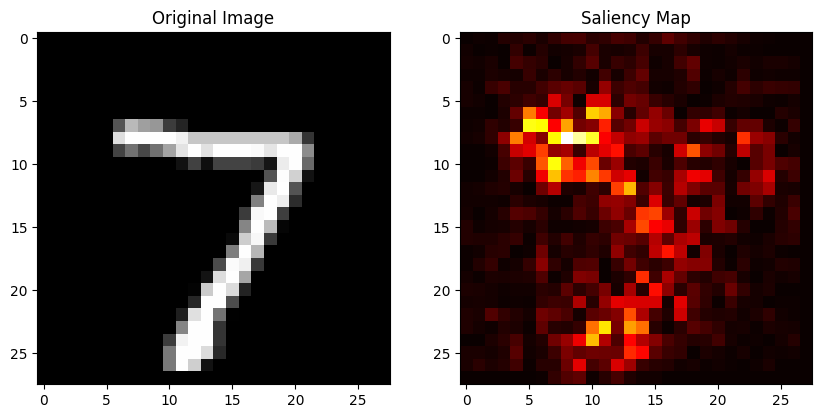

TV Regularized Saliency:


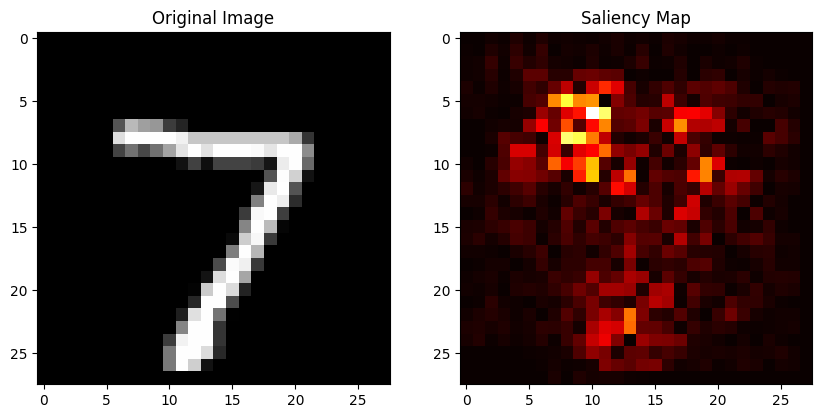

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Hyperparameters
lambda_ = 0.1  # KL loss weight
gamma = 0.01    # TV loss weight
k = 50          # Features to mask
batch_size = 128
epochs = 10
lr = 0.001

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(9216, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def train(model, loader, optimizer, device, use_tv=True):
    model.train()
    total_loss = 0
    correct = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad_(True)

        # Forward pass
        outputs = model(inputs)
        ce_loss = nn.CrossEntropyLoss()(outputs, labels)

        # Saliency map
        batch_indices = (torch.arange(inputs.size(0)), labels)
        logits_true = outputs[batch_indices]
        saliency = torch.autograd.grad(logits_true.sum(), inputs, create_graph=True)[0].abs()

        # Mask k lowest saliency features
        batch_size, _, h, w = inputs.shape
        saliency_flat = saliency.view(batch_size, -1)
        _, indices = torch.topk(-saliency_flat, k, dim=1)
        mask = torch.ones_like(inputs)
        for i in range(batch_size):
            flat_mask = torch.ones(h*w, device=device)
            flat_mask[indices[i]] = 0
            mask[i] = flat_mask.view(1, h, w)
        masked_inputs = inputs * mask

        # KL divergence
        outputs_masked = model(masked_inputs)
        kl_loss = nn.KLDivLoss(reduction='batchmean')(
            nn.LogSoftmax(dim=1)(outputs_masked),
            nn.Softmax(dim=1)(outputs.detach())
        )

        # TV regularization (corrected)
        tv_loss = 0
        if use_tv:
        # Calculate gradients with matching dimensions
          diff_x = saliency[:, :, 1:, :-1] - saliency[:, :, :-1, :-1]  # (B,C,H-1,W-1)
          diff_y = saliency[:, :, :-1, 1:] - saliency[:, :, :-1, :-1]  # (B,C,H-1,W-1)
          tv_loss = (nn.Softmax(dim=1)((nn.LogSoftmax(dim=1)((diff_x**2 + diff_y**2 + 1e-8)))).sqrt().sum())/len(diff_y)

        # Total loss
        loss = ce_loss + lambda_ * kl_loss + gamma * tv_loss

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = outputs.argmax(dim=1)
        correct += pred.eq(labels).sum().item()

    return total_loss/len(loader), correct/len(loader.dataset)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = {'Simple SGT': CNN().to(device), 'TV Regularized': CNN().to(device)}
results = {}

# Train both models
for name in models:
    optimizer = optim.Adam(models[name].parameters(), lr=lr)
    print(f'Training {name}...')
    epoch_loss, epoch_acc = [], []
    for epoch in range(epochs):
        loss, acc = train(models[name], train_loader, optimizer, device, use_tv=(name=='TV Regularized'))
        epoch_loss.append(loss)
        epoch_acc.append(acc)
        print(f'Epoch {epoch+1}: Loss={loss:.4f}, Acc={acc:.4f}')
    results[name] = {'loss': epoch_loss, 'acc': epoch_acc}

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(121)
for name in results:
    plt.plot(results[name]['loss'], label=name)
plt.title('Training Loss')
plt.legend()

plt.subplot(122)
for name in results:
    plt.plot(results[name]['acc'], label=name)
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Saliency visualization
def plot_saliency(model, device):
    data, label = next(iter(test_loader))
    input = data[0:1].to(device).requires_grad_()
    output = model(input)
    saliency = torch.autograd.grad(output.max(1)[0].sum(), input)[0].abs().squeeze().cpu()

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(data[0].squeeze(), cmap='gray')
    plt.title('Original Image')
    plt.subplot(122)
    plt.imshow(saliency, cmap='hot')
    plt.title('Saliency Map')
    plt.show()

for name in models:
    print(f'{name} Saliency:')
    plot_saliency(models[name], device)

Simple SGT Saliency:


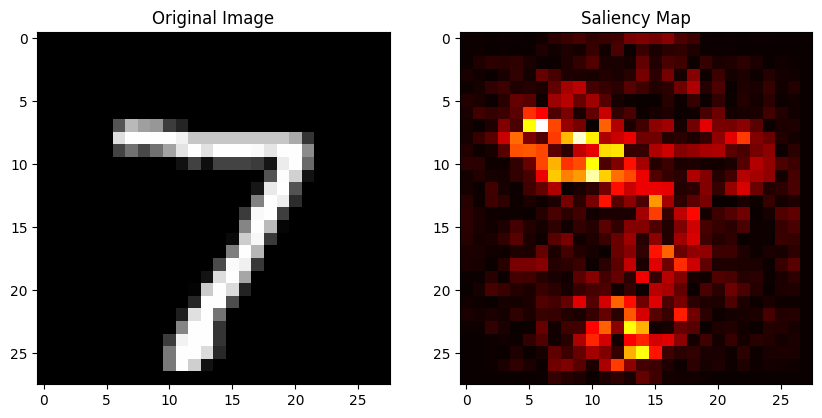

TV Regularized Saliency:


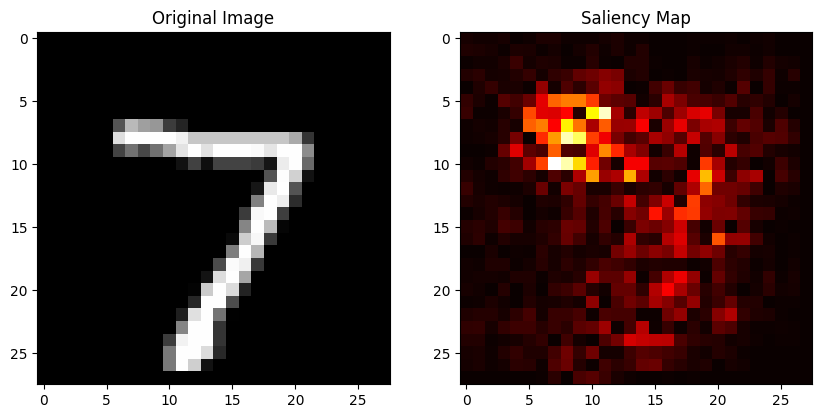

In [ ]:
# Saliency visualization
def plot_saliency(model, device):
    data, label = next(iter(test_loader))
    input = data[0:1].to(device).requires_grad_()
    output = model(input)
    saliency = torch.autograd.grad(output.max(1)[0].sum(), input)[0].abs().squeeze().cpu()

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(data[0].squeeze(), cmap='gray')
    plt.title('Original Image')
    plt.subplot(122)
    plt.imshow(saliency, cmap='hot')
    plt.title('Saliency Map')
    plt.show()

for name in models:
    print(f'{name} Saliency:')
    plot_saliency(models[name], device)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Hyperparameters
lambda_ = 0.1   # KL loss weight
gamma = 0.01    # TV loss weight
k = 50          # Number of features to mask
batch_size = 128
epochs = 10
lr = 0.001

# CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    # Optional: normalize CIFAR-10 images (mean and std for RGB)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

# CNN Model for CIFAR-10
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Change input channels to 3 for RGB images
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout = nn.Dropout(0.5)
        # Compute feature map size:
        # Input: (3, 32, 32) -> conv1: (32, 30, 30) -> conv2: (64, 28, 28)
        # After MaxPool2d(2): (64, 14, 14)
        self.fc = nn.Linear(64 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def train(model, loader, optimizer, device, use_tv=True):
    model.train()
    total_loss = 0
    correct = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad_(True)

        # Forward pass
        outputs = model(inputs)
        ce_loss = nn.CrossEntropyLoss()(outputs, labels)

        # Saliency map computation
        batch_indices = (torch.arange(inputs.size(0), device=device), labels)
        logits_true = outputs[batch_indices]
        saliency = torch.autograd.grad(logits_true.sum(), inputs, create_graph=True)[0].abs()

        batch_size, _, h, w = inputs.shape
        saliency_flat = saliency.view(batch_size, -1)
        _, indices = torch.topk(-saliency_flat, k, dim=1)
        mask = torch.ones_like(inputs)
        for i in range(batch_size):
            # Create a flat mask with size = 3 * h * w for RGB images
            flat_mask = torch.ones(3 * h * w, device=device)
            flat_mask[indices[i]] = 0
            mask[i] = flat_mask.view(3, h, w)
        masked_inputs = inputs * mask
        # KL divergence between original and masked outputs
        outputs_masked = model(masked_inputs)
        kl_loss = nn.KLDivLoss(reduction='batchmean')(
            nn.LogSoftmax(dim=1)(outputs_masked),
            nn.Softmax(dim=1)(outputs.detach())
        )

        # TV regularization (corrected)
        tv_loss = 0
        if use_tv:
            diff_x = saliency[:, :, 1:, :-1] - saliency[:, :, :-1, :-1]
            diff_y = saliency[:, :, :-1, 1:] - saliency[:, :, :-1, :-1]
            tv_loss = (nn.Softmax(dim=1)(
                        nn.LogSoftmax(dim=1)(diff_x**2 + diff_y**2 + 1e-8)
                     ).sqrt().sum()) / len(diff_y)

        # Total loss
        loss = ce_loss + lambda_ * kl_loss + gamma * tv_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = outputs.argmax(dim=1)
        correct += pred.eq(labels).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = {'Simple SGT': CNN().to(device), 'TV Regularized': CNN().to(device)}
results = {}

# Train both models
for name in models:
    optimizer = optim.Adam(models[name].parameters(), lr=lr)
    print(f'Training {name}...')
    epoch_loss, epoch_acc = [], []
    for epoch in range(epochs):
        loss, acc = train(models[name], train_loader, optimizer, device, use_tv=(name=='TV Regularized'))
        epoch_loss.append(loss)
        epoch_acc.append(acc)
        print(f'Epoch {epoch+1}: Loss={loss:.4f}, Acc={acc:.4f}')
    results[name] = {'loss': epoch_loss, 'acc': epoch_acc}

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(121)
for name in results:
    plt.plot(results[name]['loss'], label=name)
plt.title('Training Loss')
plt.legend()

plt.subplot(122)
for name in results:
    plt.plot(results[name]['acc'], label=name)
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Saliency visualization for CIFAR-10 images
def plot_saliency(model, device):
    data, label = next(iter(test_loader))
    input_img = data[0:1].to(device).requires_grad_(True)
    output = model(input_img)
    saliency = torch.autograd.grad(output.max(1)[0].sum(), input_img)[0].abs().squeeze().cpu()

    # Convert the tensor image to a NumPy array for plotting
    # For CIFAR-10, images are RGB; transpose dimensions from (C, H, W) to (H, W, C)
    img = data[0].permute(1, 2, 0).numpy()
    # If normalization was applied, unnormalize the image
    img = (img * 0.5) + 0.5  # assuming normalization with mean=0.5 and std=0.5

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(img)
    plt.title('Original Image')
    plt.subplot(122)
    plt.imshow(saliency, cmap='hot')
    plt.title('Saliency Map')
    plt.show()

for name in models:
    print(f'{name} Saliency:')
    plot_saliency(models[name], device)


Files already downloaded and verified
Files already downloaded and verified


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Files already downloaded and verified
Files already downloaded and verified
Training Simple SGT...
Epoch 1: Loss=1.5449, Acc=0.4485
Epoch 2: Loss=1.2404, Acc=0.5659
Epoch 3: Loss=1.1183, Acc=0.6129
Epoch 4: Loss=1.0419, Acc=0.6405
Epoch 5: Loss=0.9919, Acc=0.6607
Epoch 6: Loss=0.9526, Acc=0.6755
Epoch 7: Loss=0.9184, Acc=0.6872
Epoch 8: Loss=0.8963, Acc=0.6972
Epoch 9: Loss=0.8755, Acc=0.7015
Epoch 10: Loss=0.8524, Acc=0.7118
Training TV Regularized...
Epoch 1: Loss=6.4174, Acc=0.4411
Epoch 2: Loss=6.0358, Acc=0.5531
Epoch 3: Loss=5.9847, Acc=0.5921
Epoch 4: Loss=5.9211, Acc=0.6208
Epoch 5: Loss=5.8849, Acc=0.6380
Epoch 6: Loss=5.8297, Acc=0.6524
Epoch 7: Loss=5.8058, Acc=0.6626
Epoch 8: Loss=5.7771, Acc=0.6731
Epoch 9: Loss=5.7385, Acc=0.6801
Epoch 10: Loss=5.7246, Acc=0.6852


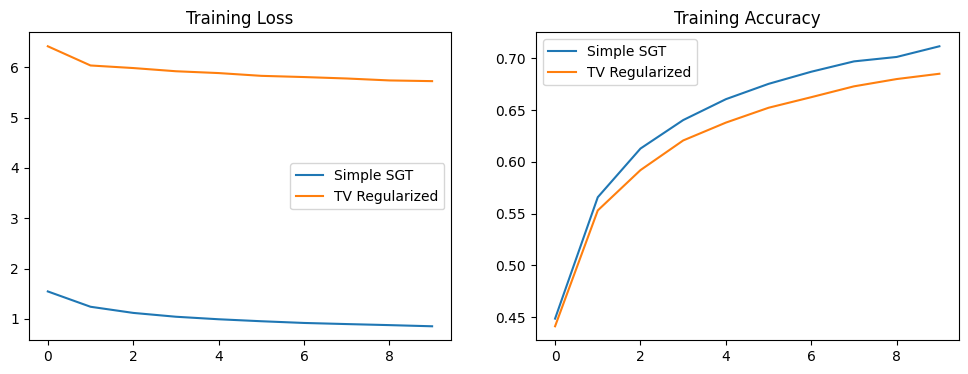

Simple SGT Saliency:


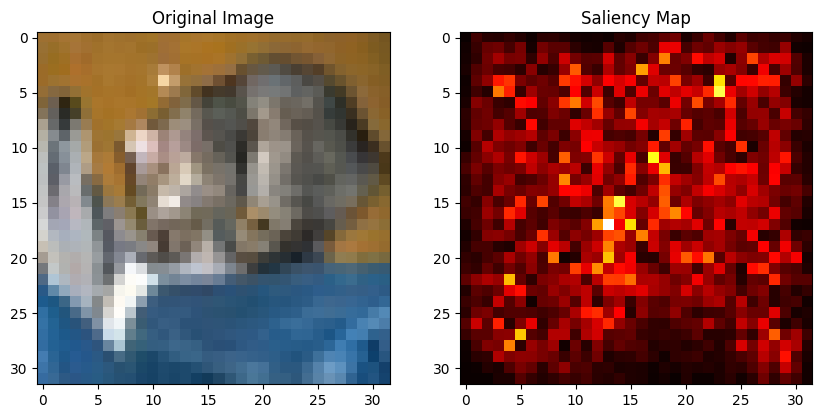

TV Regularized Saliency:


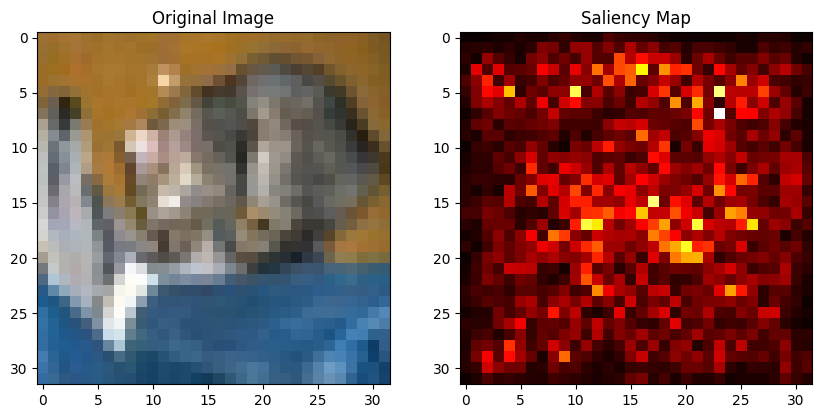

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Hyperparameters
lambda_ = 0.1  # KL loss weight
gamma = 0.1*0.5    # TV loss weight
k = 50          # Features to mask
batch_size = 128
epochs = 10
lr = 0.001

# CIFAR10 Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

# CNN Model (Adjusted for CIFAR10)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)  # 3 input channels for CIFAR10
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(12544, 10)  # Adjusted for CIFAR10 dimensions

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def train(model, loader, optimizer, device, use_tv=True):
    model.train()
    total_loss = 0
    correct = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad_(True)

        # Forward pass
        outputs = model(inputs)
        ce_loss = nn.CrossEntropyLoss()(outputs, labels)

        # Saliency map
        batch_indices = (torch.arange(inputs.size(0)), labels)
        logits_true = outputs[batch_indices]
        saliency = torch.autograd.grad(logits_true.sum(), inputs, create_graph=True)[0].abs()

        # Mask k lowest saliency features
        batch_size, _, h, w = inputs.shape
        saliency_sum = saliency.sum(dim=1)  # Sum across channels
        saliency_flat = saliency_sum.view(batch_size, -1)
        _, indices = torch.topk(-saliency_flat, k, dim=1)
        mask = torch.ones_like(inputs)
        for i in range(batch_size):
            flat_mask = torch.ones(h * w, device=device)
            flat_mask[indices[i]] = 0
            spatial_mask = flat_mask.view(h, w)
            mask[i] = spatial_mask.unsqueeze(0).repeat(3, 1, 1)  # Expand to 3 channels
        masked_inputs = inputs * mask

        # KL divergence
        outputs_masked = model(masked_inputs)
        kl_loss = nn.KLDivLoss(reduction='batchmean')(
            nn.LogSoftmax(dim=1)(outputs_masked),
            nn.Softmax(dim=1)(outputs.detach())
        )

        # TV regularization on MASK (modified section)
        tv_loss = 0
        if use_tv:
            # Use first channel (all channels have same mask)
            mask_tv = mask[:, 0, :, :]  # Shape: (batch_size, h, w)

            # Calculate horizontal differences
            diff_x = mask_tv[:, 1:, :] - mask_tv[:, :-1, :]  # Left-right differences
            # Calculate vertical differences
            diff_y = mask_tv[:, :, 1:] - mask_tv[:, :, :-1]  # Top-bottom differences

            # Calculate TV loss
            tv_loss = (diff_x.abs().sum() + diff_y.abs().sum()) / inputs.size(0)

        # Total loss
        loss = ce_loss + lambda_ * kl_loss + gamma * tv_loss

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = outputs.argmax(dim=1)
        correct += pred.eq(labels).sum().item()

    return total_loss/len(loader), correct/len(loader.dataset)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = {'Simple SGT': CNN().to(device), 'TV Regularized': CNN().to(device)}
results = {}

# Train both models
for name in models:
    optimizer = optim.Adam(models[name].parameters(), lr=lr)
    print(f'Training {name}...')
    epoch_loss, epoch_acc = [], []
    for epoch in range(epochs):
        loss, acc = train(models[name], train_loader, optimizer, device, use_tv=(name=='TV Regularized'))
        epoch_loss.append(loss)
        epoch_acc.append(acc)
        print(f'Epoch {epoch+1}: Loss={loss:.4f}, Acc={acc:.4f}')
    results[name] = {'loss': epoch_loss, 'acc': epoch_acc}

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(121)
for name in results:
    plt.plot(results[name]['loss'], label=name)
plt.title('Training Loss')
plt.legend()

plt.subplot(122)
for name in results:
    plt.plot(results[name]['acc'], label=name)
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Saliency visualization (adjusted for CIFAR10)
def plot_saliency(model, device):
    data, label = next(iter(test_loader))
    input = data[0:1].to(device).requires_grad_()
    output = model(input)
    saliency = torch.autograd.grad(output.max(1)[0].sum(), input)[0].abs().squeeze().cpu()

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(data[0].permute(1, 2, 0))  # CIFAR10 color image
    plt.title('Original Image')
    plt.subplot(122)
    plt.imshow(saliency.sum(dim=0), cmap='hot')  # Sum across channels
    plt.title('Saliency Map')
    plt.show()

for name in models:
    print(f'{name} Saliency:')
    plot_saliency(models[name], device)

0
Simple SGT Saliency:


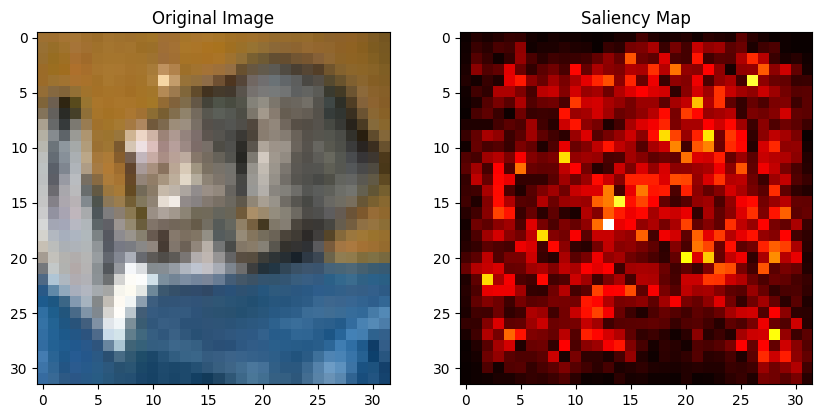

0
TV Regularized Saliency:


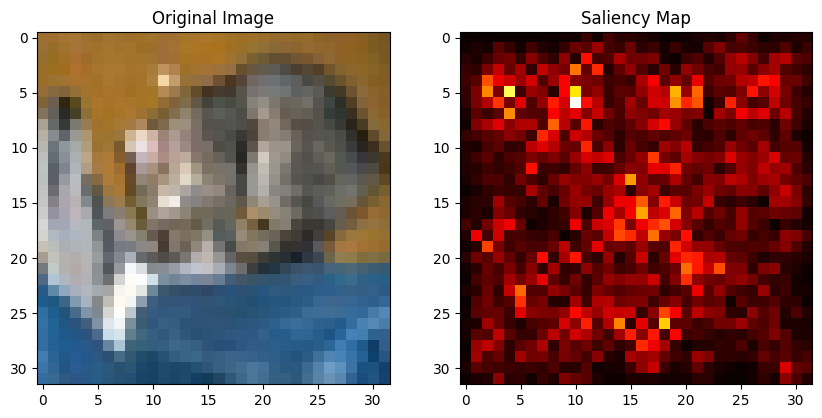

1
Simple SGT Saliency:


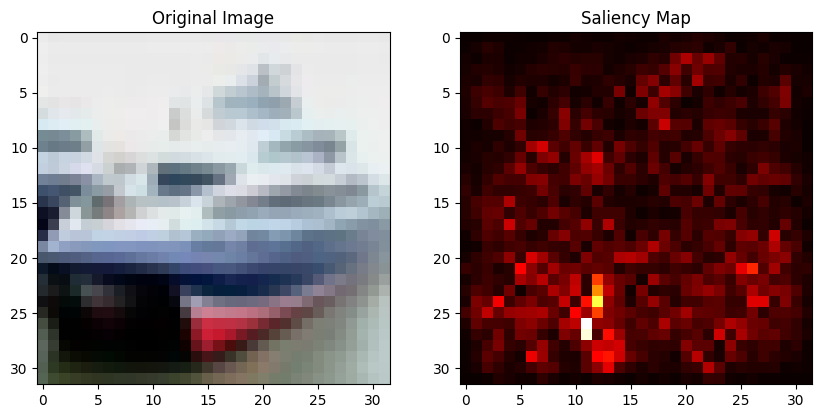

1
TV Regularized Saliency:


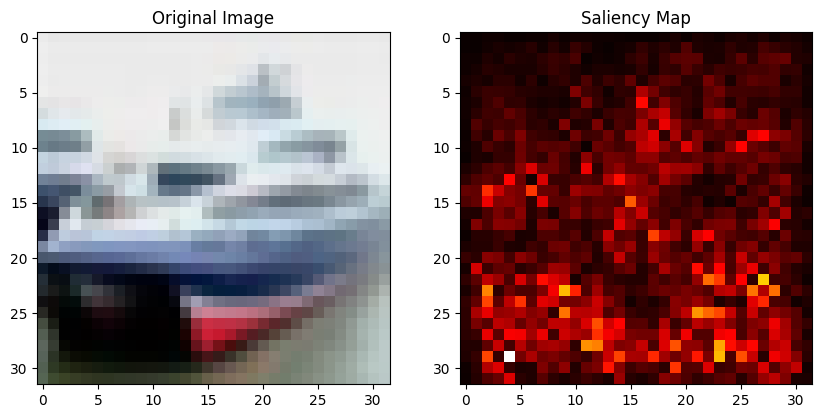

2
Simple SGT Saliency:


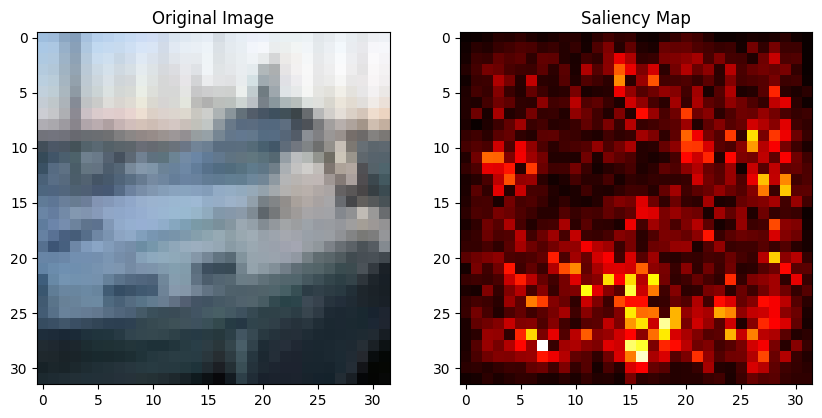

2
TV Regularized Saliency:


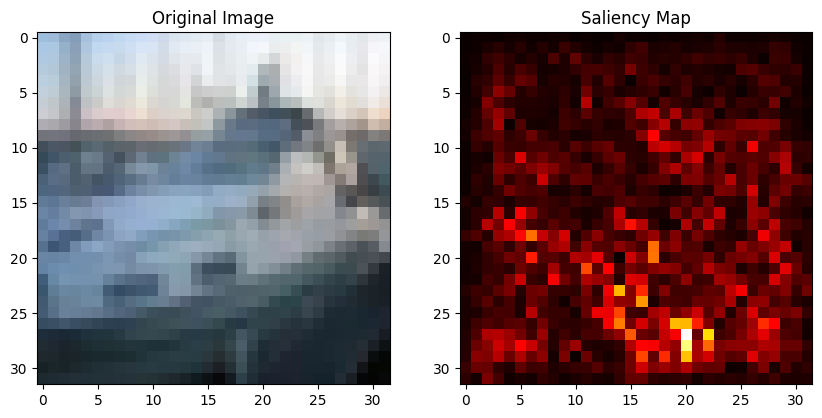

3
Simple SGT Saliency:


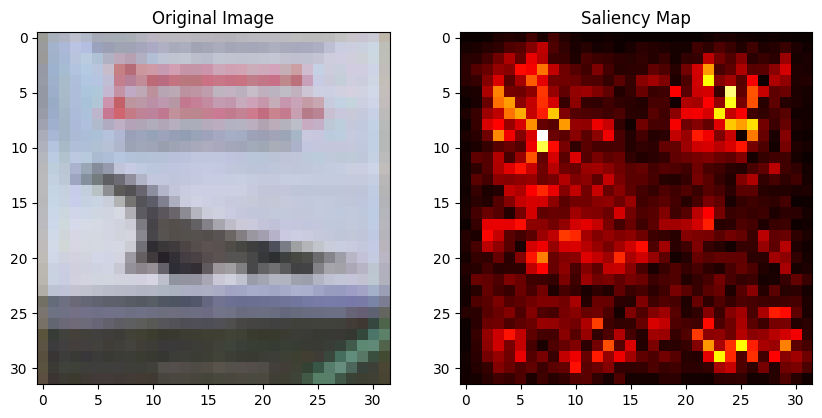

3
TV Regularized Saliency:


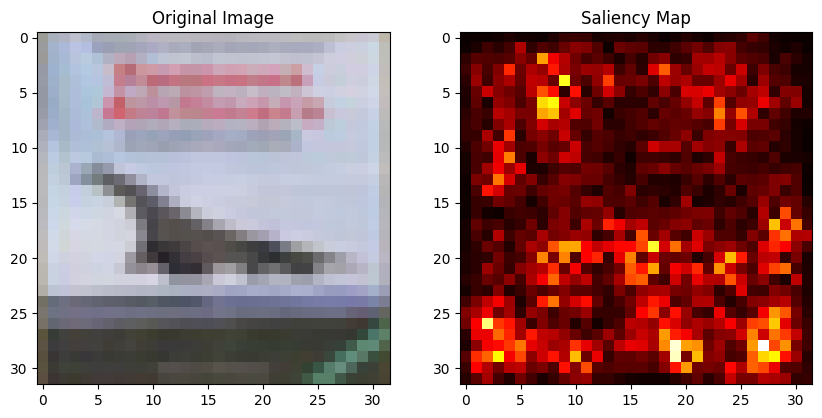

4
Simple SGT Saliency:


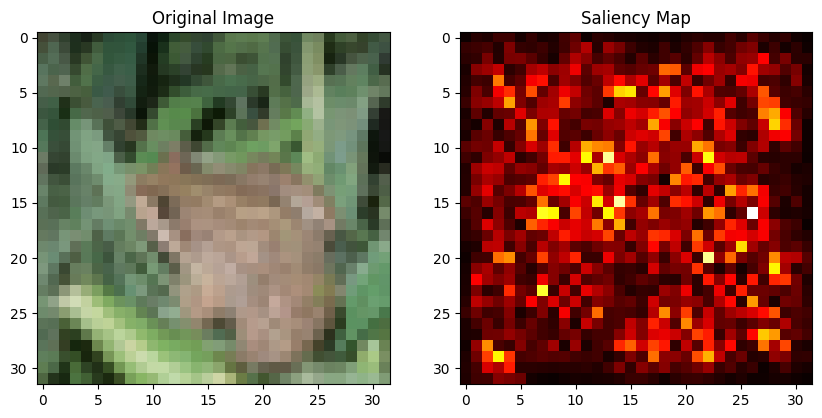

4
TV Regularized Saliency:


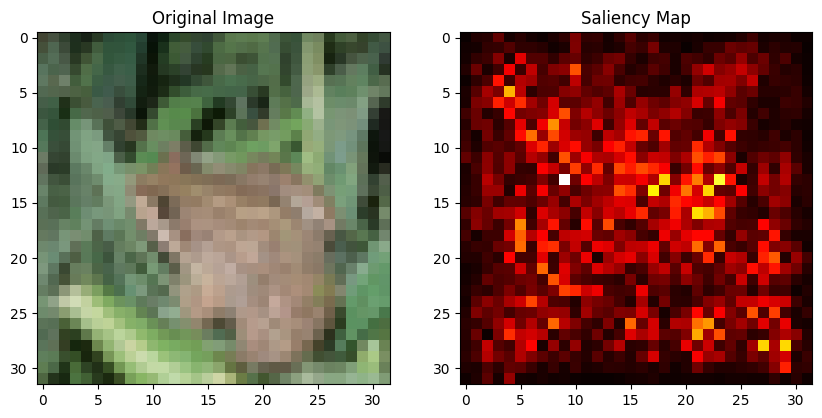

5
Simple SGT Saliency:


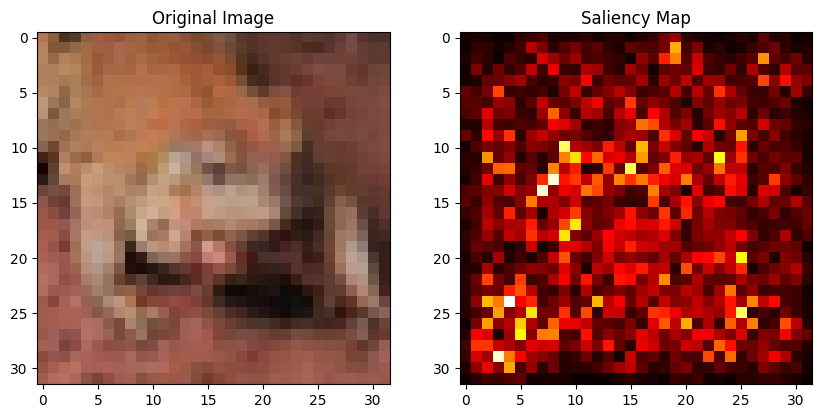

5
TV Regularized Saliency:


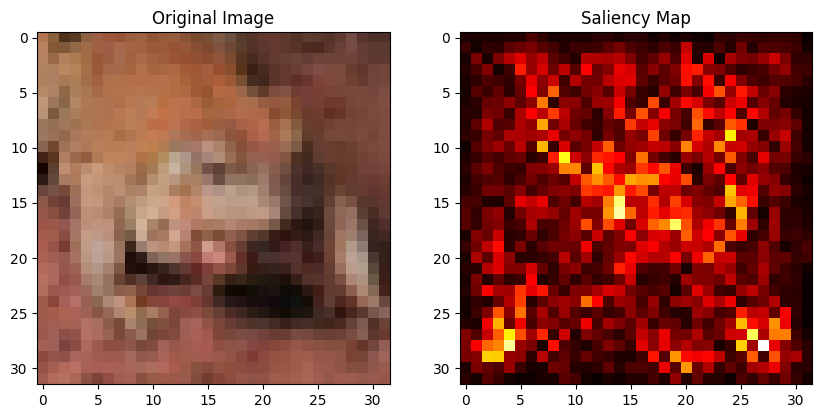

6
Simple SGT Saliency:


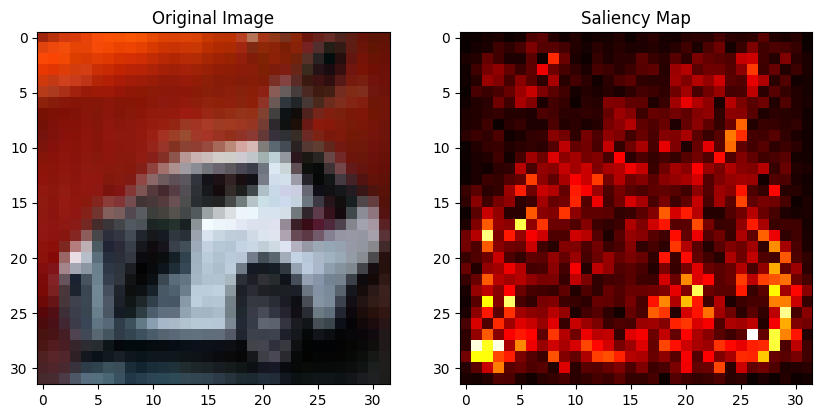

6
TV Regularized Saliency:


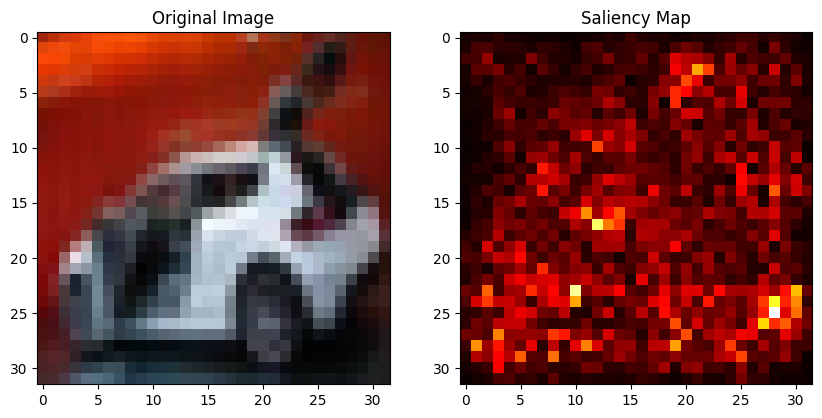

7
Simple SGT Saliency:


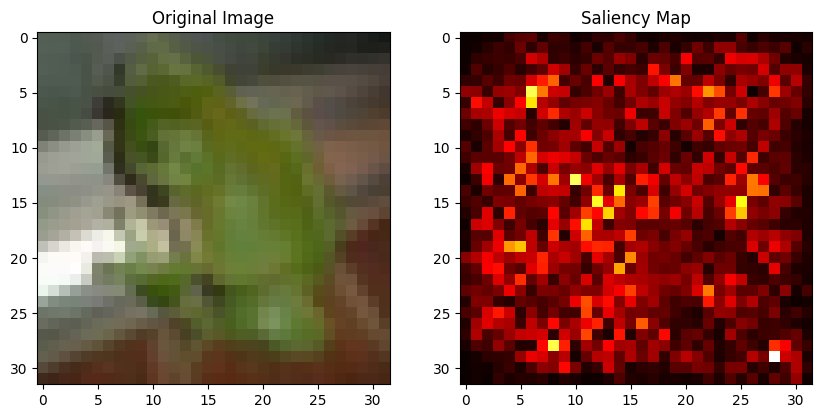

7
TV Regularized Saliency:


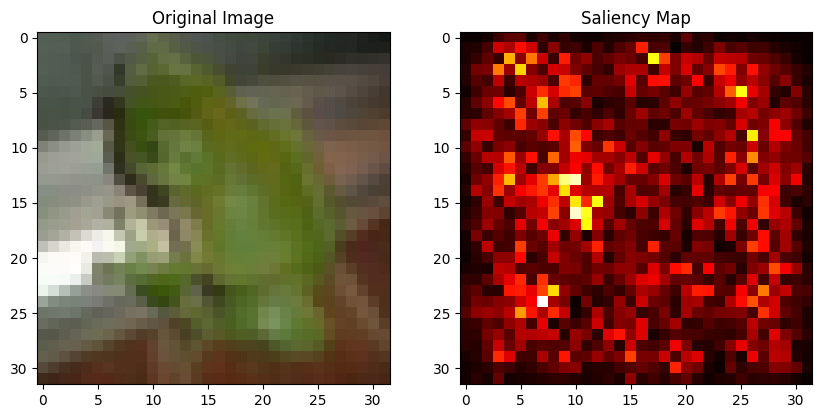

8
Simple SGT Saliency:


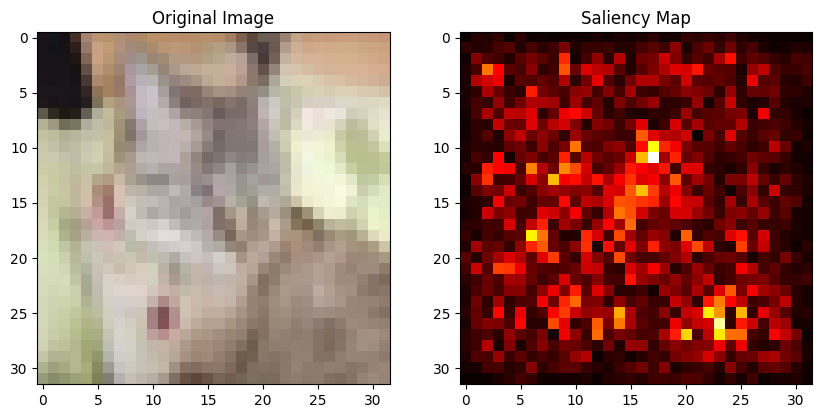

8
TV Regularized Saliency:


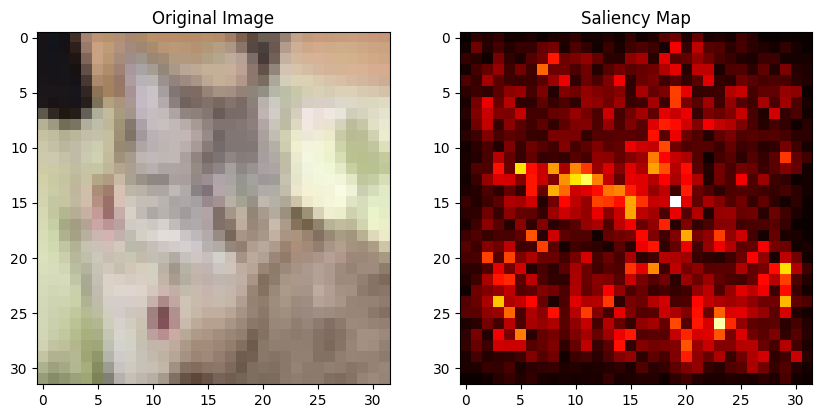

9
Simple SGT Saliency:


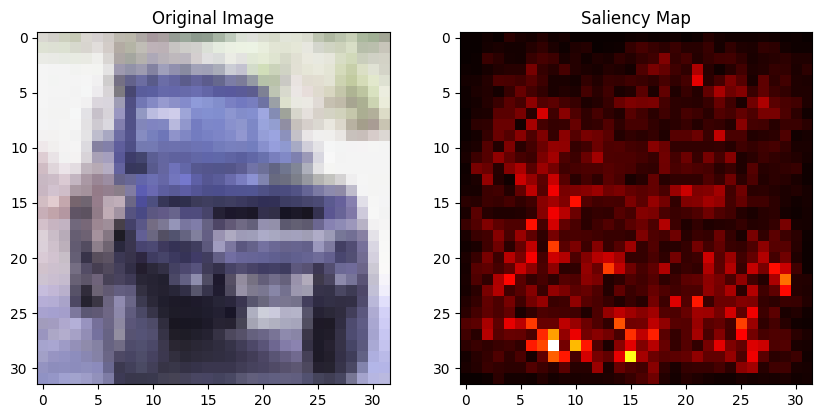

9
TV Regularized Saliency:


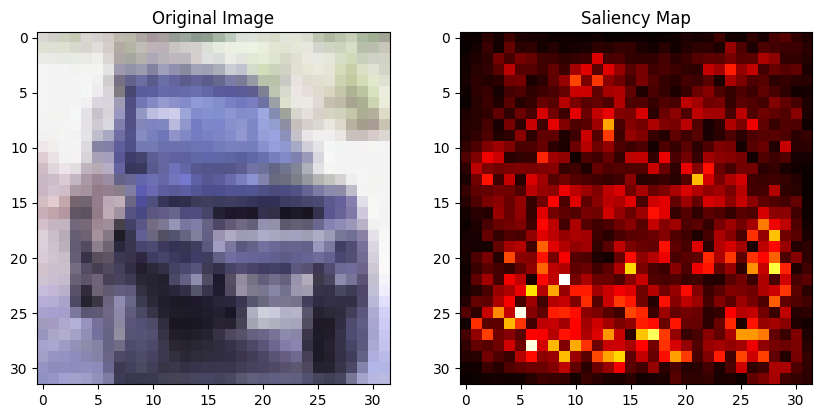

In [ ]:
# Saliency visualization (adjusted for CIFAR10)
def plot_saliency(model, device,i):
    data, label = next(iter(test_loader))
    input = data[i:i+1].to(device).requires_grad_()
    output = model(input)
    saliency = torch.autograd.grad(output.max(1)[0].sum(), input)[0].abs().squeeze().cpu()

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(data[i].permute(1, 2, 0))  # CIFAR10 color image
    plt.title('Original Image')
    plt.subplot(122)
    plt.imshow(saliency.sum(dim=0), cmap='hot')  # Sum across channels
    plt.title('Saliency Map')
    plt.show()
for i in range(10):
  for name in models:
      print(i)
      print(f'{name} Saliency:')
      plot_saliency(models[name], device, i)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
lambda_ = 0.1  # KL loss weight
gamma = 0.1    # TV loss weight
k = 50          # Features to mask
batch_size = 128
epochs = 10
lr = 0.001

# CIFAR10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

# CNN Model with GradCAM hooks
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64 * 8 * 8, 10)  # Adjusted for CIFAR10 size

        # GradCAM hooks
        self.gradients = None
        self.activations = None
        self.conv2.register_forward_hook(self.save_activations)
        self.conv2.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))  # 16x16
        x = self.pool(nn.ReLU()(self.conv2(x)))  # 8x8
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def compute_tv_loss(mask):
    # Calculate TV loss on mask (batch_size, channels, h, w)
    diff_h = torch.abs(mask[:, :, 1:, :] - mask[:, :, :-1, :]).sum()
    diff_w = torch.abs(mask[:, :, :, 1:] - mask[:, :, :, :-1]).sum()
    return (diff_h + diff_w) / mask.size(0)

def train(model, loader, optimizer, device, use_tv=True):
    model.train()
    total_loss, correct = 0, 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad_(True)

        # Forward pass
        outputs = model(inputs)
        ce_loss = nn.CrossEntropyLoss()(outputs, labels)

        # Saliency computation
        batch_indices = (torch.arange(inputs.size(0)), labels)
        logits_true = outputs[batch_indices]
        saliency = torch.autograd.grad(logits_true.sum(), inputs, create_graph=True)[0].abs()

        # Create mask
        batch_size, _, h, w = inputs.shape
        saliency_sum = saliency.sum(1)  # Sum across channels
        saliency_flat = saliency_sum.view(batch_size, -1)
        _, indices = torch.topk(-saliency_flat, k, 1)

        mask = torch.ones_like(inputs)
        for i in range(batch_size):
            flat_mask = torch.ones(h*w, device=device)
            flat_mask[indices[i]] = 0
            mask[i] = flat_mask.view(1, h, w).repeat(3, 1, 1)

        masked_inputs = inputs * mask

        # KL divergence
        outputs_masked = model(masked_inputs)
        kl_loss = nn.KLDivLoss(reduction='batchmean')(
            nn.LogSoftmax(1)(outputs_masked),
            nn.Softmax(1)(outputs.detach())
        )

        # TV loss on mask
        # TV regularization on MASK (modified section)
        tv_loss = 0
        if use_tv:
            # Use first channel (all channels have same mask)
            mask_tv = mask[:, 0, :, :]  # Shape: (batch_size, h, w)

            # Calculate horizontal differences
            diff_x = mask_tv[:, 1:, :] - mask_tv[:, :-1, :]  # Left-right differences
            # Calculate vertical differences
            diff_y = mask_tv[:, :, 1:] - mask_tv[:, :, :-1]  # Top-bottom differences

            # Calculate TV loss
            tv_loss = (diff_x.abs().sum() + diff_y.abs().sum()) / inputs.size(0)

        # Total loss
        loss = ce_loss + lambda_*kl_loss + gamma*tv_loss

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += outputs.argmax(1).eq(labels).sum().item()

    return total_loss/len(loader), correct/len(loader.dataset)

def grad_cam(model, input_tensor, device):
    model.eval()
    input_tensor = input_tensor.to(device).requires_grad_(True)

    # Forward pass
    output = model(input_tensor)
    class_idx = output.argmax().item()

    # Backward pass
    model.zero_grad()
    output[0, class_idx].backward()

    # GradCAM calculation
    gradients = model.gradients
    activations = model.activations

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    weighted_activations = activations * pooled_gradients[None, :, None, None]
    heatmap = torch.mean(weighted_activations, dim=1).squeeze()
    heatmap = nn.ReLU()(heatmap)

    # Normalize and resize
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = torch.nn.functional.interpolate(
        heatmap[None, None, :, :],
        size=(32, 32),
        mode='bilinear',
        align_corners=False
    ).squeeze()

    return heatmap.cpu().detach().numpy()

def visualize_results(model, device, num_images=5):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(15, 5*num_images))
    for idx in range(num_images):
        img = images[idx].permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # Unnormalize

        # Create input tensor with gradients
        input_tensor = images[idx:idx+1].to(device).requires_grad_(True)

        # Saliency map
        output = model(input_tensor)
        saliency = torch.autograd.grad(output.max(1)[0].sum(), input_tensor)[0].abs().sum(1).squeeze().cpu()

        # GradCAM
        heatmap = grad_cam(model, input_tensor, device)

        # Mask visualization (corrected)
        with torch.enable_grad():
            # Recompute saliency for mask
            output = model(input_tensor)
            logit = output[0, output.argmax().item()]
            saliency_map = torch.autograd.grad(logit, input_tensor, retain_graph=True)[0].abs().sum(1).squeeze()

            saliency_flat = saliency_map.view(-1)
            _, indices = torch.topk(-saliency_flat, k)

            mask = torch.ones_like(saliency_flat)
            mask[indices] = 0
            mask = mask.view(32, 32).cpu().numpy()

        # Plotting
        plt.subplot(num_images, 4, idx*4+1)
        plt.imshow(img)
        plt.title(f'Original\nClass: {test_set.classes[labels[idx]]}')
        plt.axis('off')

        plt.subplot(num_images, 4, idx*4+2)
        plt.imshow(saliency, cmap='hot')
        plt.title('Saliency Map')
        plt.axis('off')

        plt.subplot(num_images, 4, idx*4+3)
        plt.imshow(img)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.title('GradCAM')
        plt.axis('off')

        plt.subplot(num_images, 4, idx*4+4)
        plt.imshow(mask, cmap='gray')
        plt.title('Learned Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = {'Simple SGT': CNN().to(device), 'TV Regularized': CNN().to(device)}
results = {}

# Train both models
for name in models:
    optimizer = optim.Adam(models[name].parameters(), lr=lr)
    print(f'Training {name}...')
    epoch_loss, epoch_acc = [], []
    for epoch in range(epochs):
        loss, acc = train(models[name], train_loader, optimizer, device, use_tv=(name=='TV Regularized'))
        epoch_loss.append(loss)
        epoch_acc.append(acc)
        print(f'Epoch {epoch+1}: Loss={loss:.4f}, Acc={acc:.4f}')
    results[name] = {'loss': epoch_loss, 'acc': epoch_acc}


# print('Starting training...')
# for epoch in range(epochs):
#     train_loss, train_acc = train(model, train_loader, optimizer, device)
#     print(f'Epoch {epoch+1}/{epochs}')
#     print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}%')



Files already downloaded and verified
Files already downloaded and verified
Training Simple SGT...
Epoch 1: Loss=1.5084, Acc=0.4672
Epoch 2: Loss=1.2107, Acc=0.5791
Epoch 3: Loss=1.0807, Acc=0.6289
Epoch 4: Loss=1.0096, Acc=0.6533
Epoch 5: Loss=0.9678, Acc=0.6709
Epoch 6: Loss=0.9276, Acc=0.6846
Epoch 7: Loss=0.8916, Acc=0.6972
Epoch 8: Loss=0.8702, Acc=0.7067
Epoch 9: Loss=0.8469, Acc=0.7135
Epoch 10: Loss=0.8286, Acc=0.7197
Training TV Regularized...
Epoch 1: Loss=17.3065, Acc=0.4629
Epoch 2: Loss=16.7673, Acc=0.5810
Epoch 3: Loss=16.6841, Acc=0.6253
Epoch 4: Loss=16.6199, Acc=0.6549
Epoch 5: Loss=16.5851, Acc=0.6729
Epoch 6: Loss=16.5456, Acc=0.6849
Epoch 7: Loss=16.5165, Acc=0.6982
Epoch 8: Loss=16.5120, Acc=0.7046
Epoch 9: Loss=16.4966, Acc=0.7147
Epoch 10: Loss=16.4831, Acc=0.7229



Visualizing results...
Simple SGT Saliency:


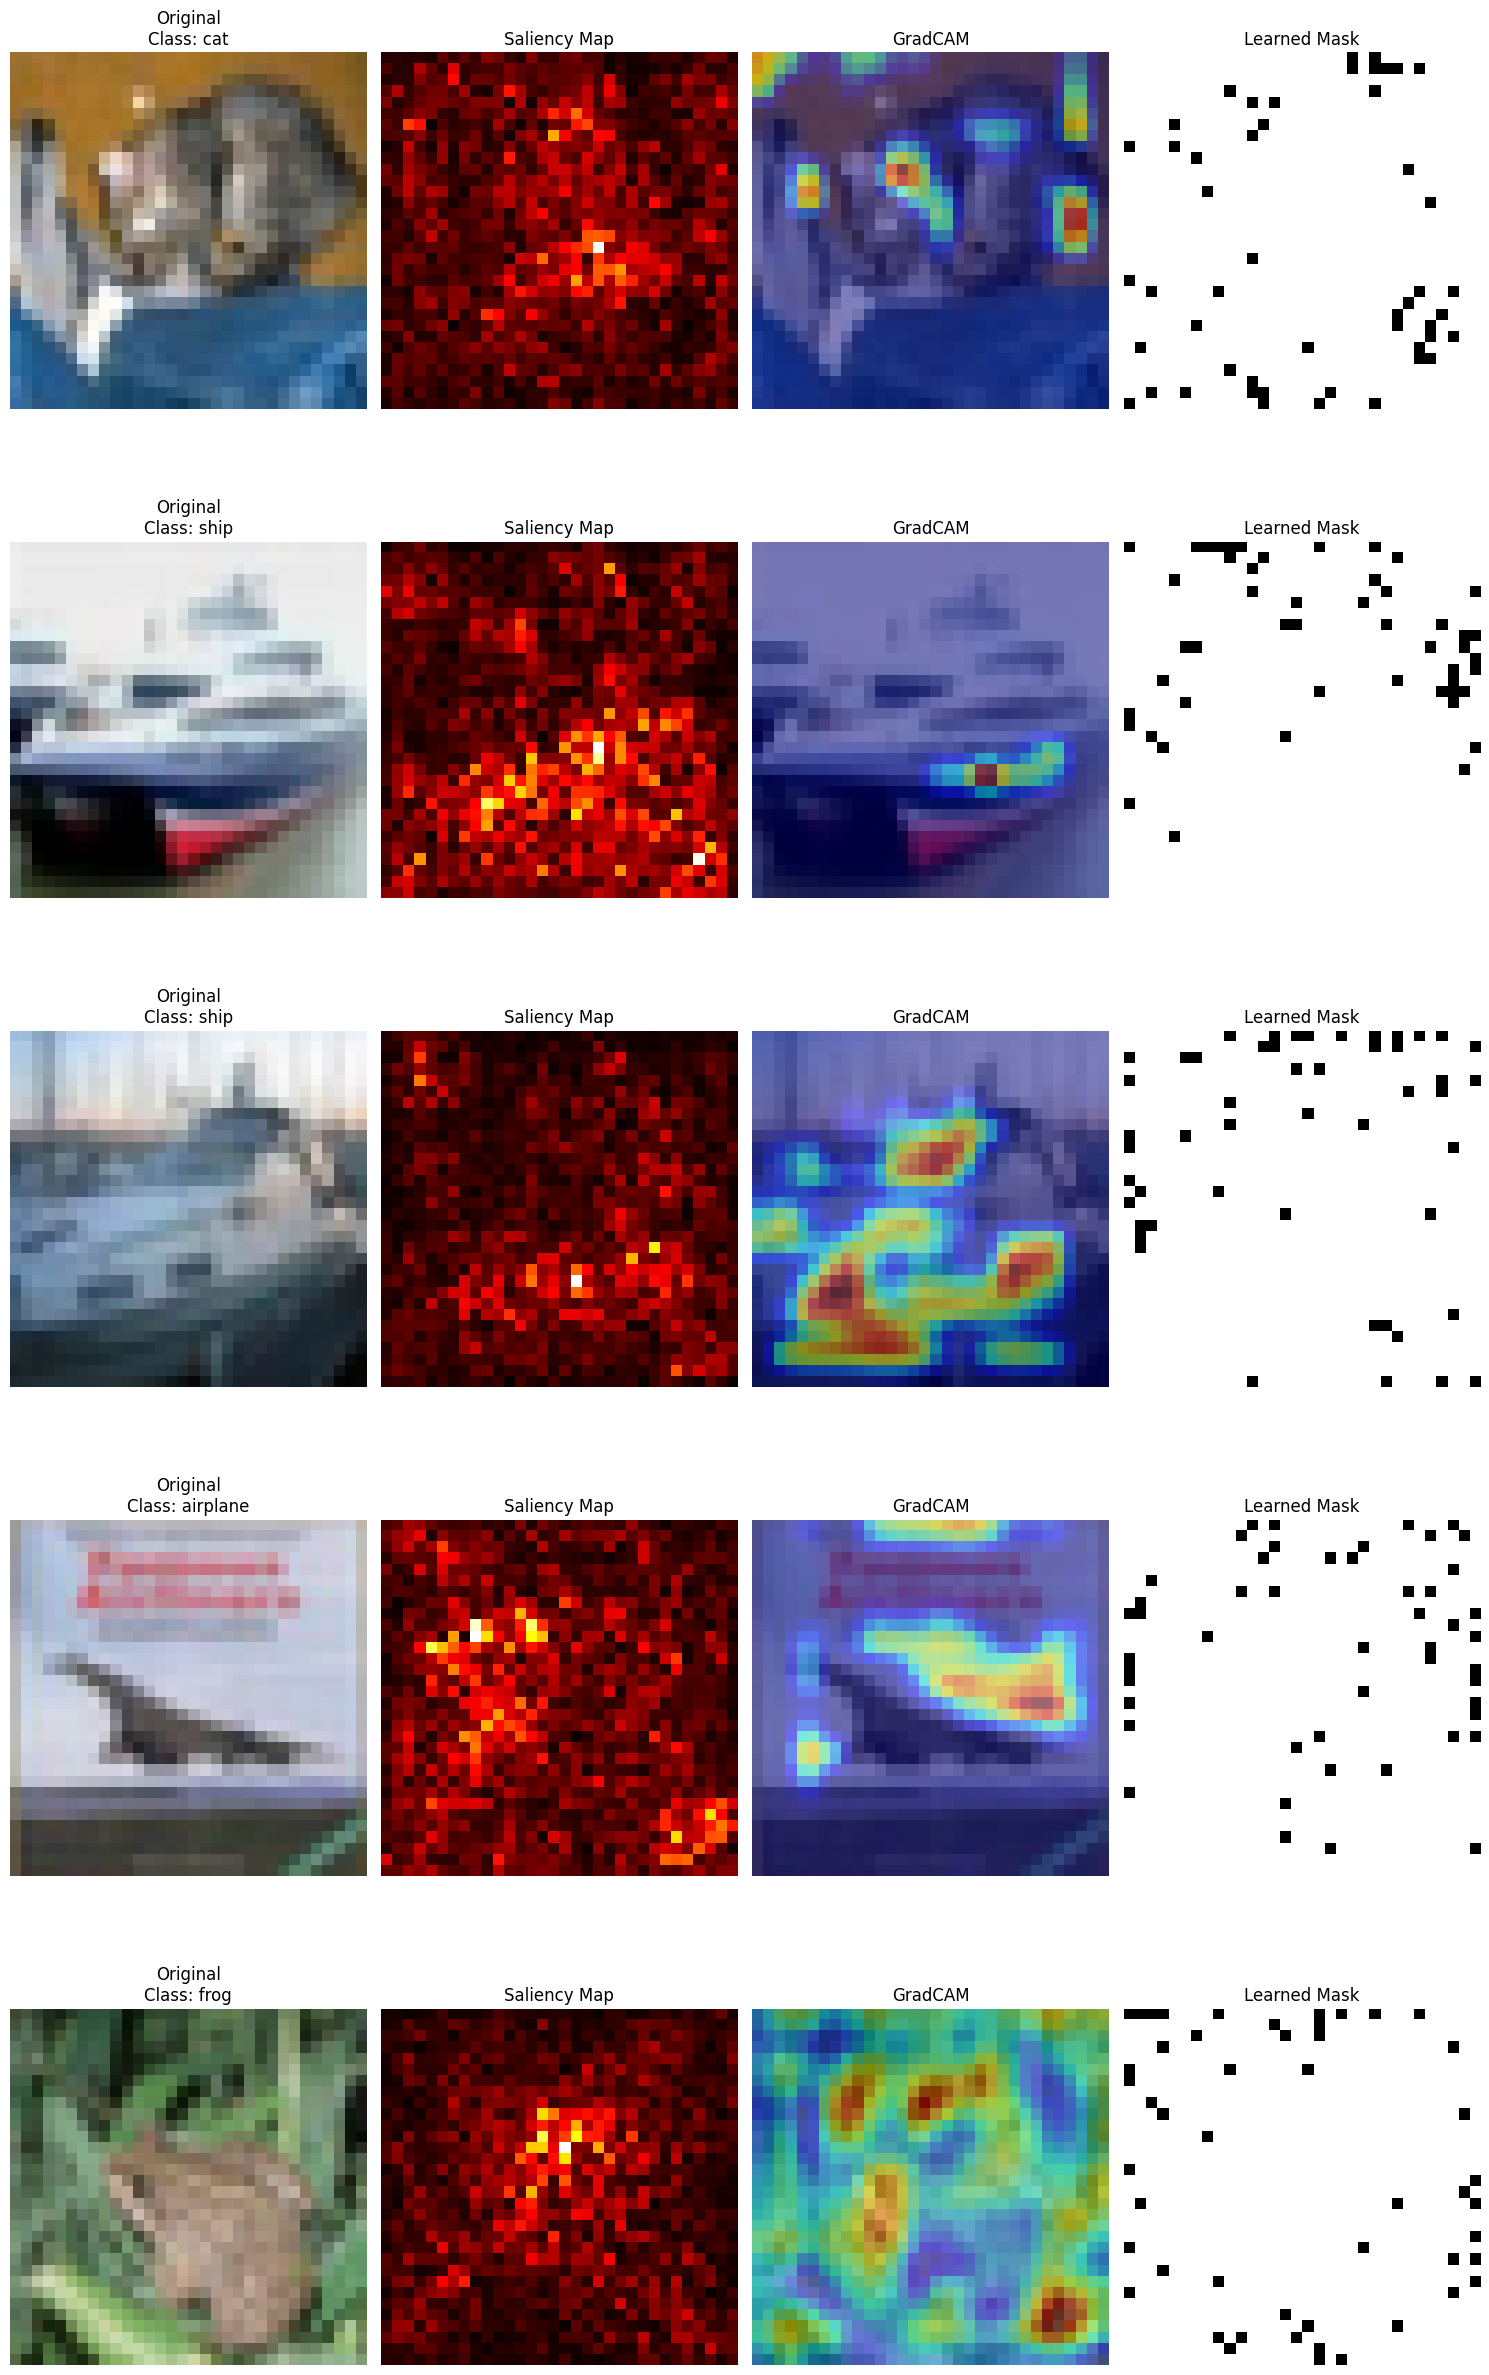

TV Regularized Saliency:


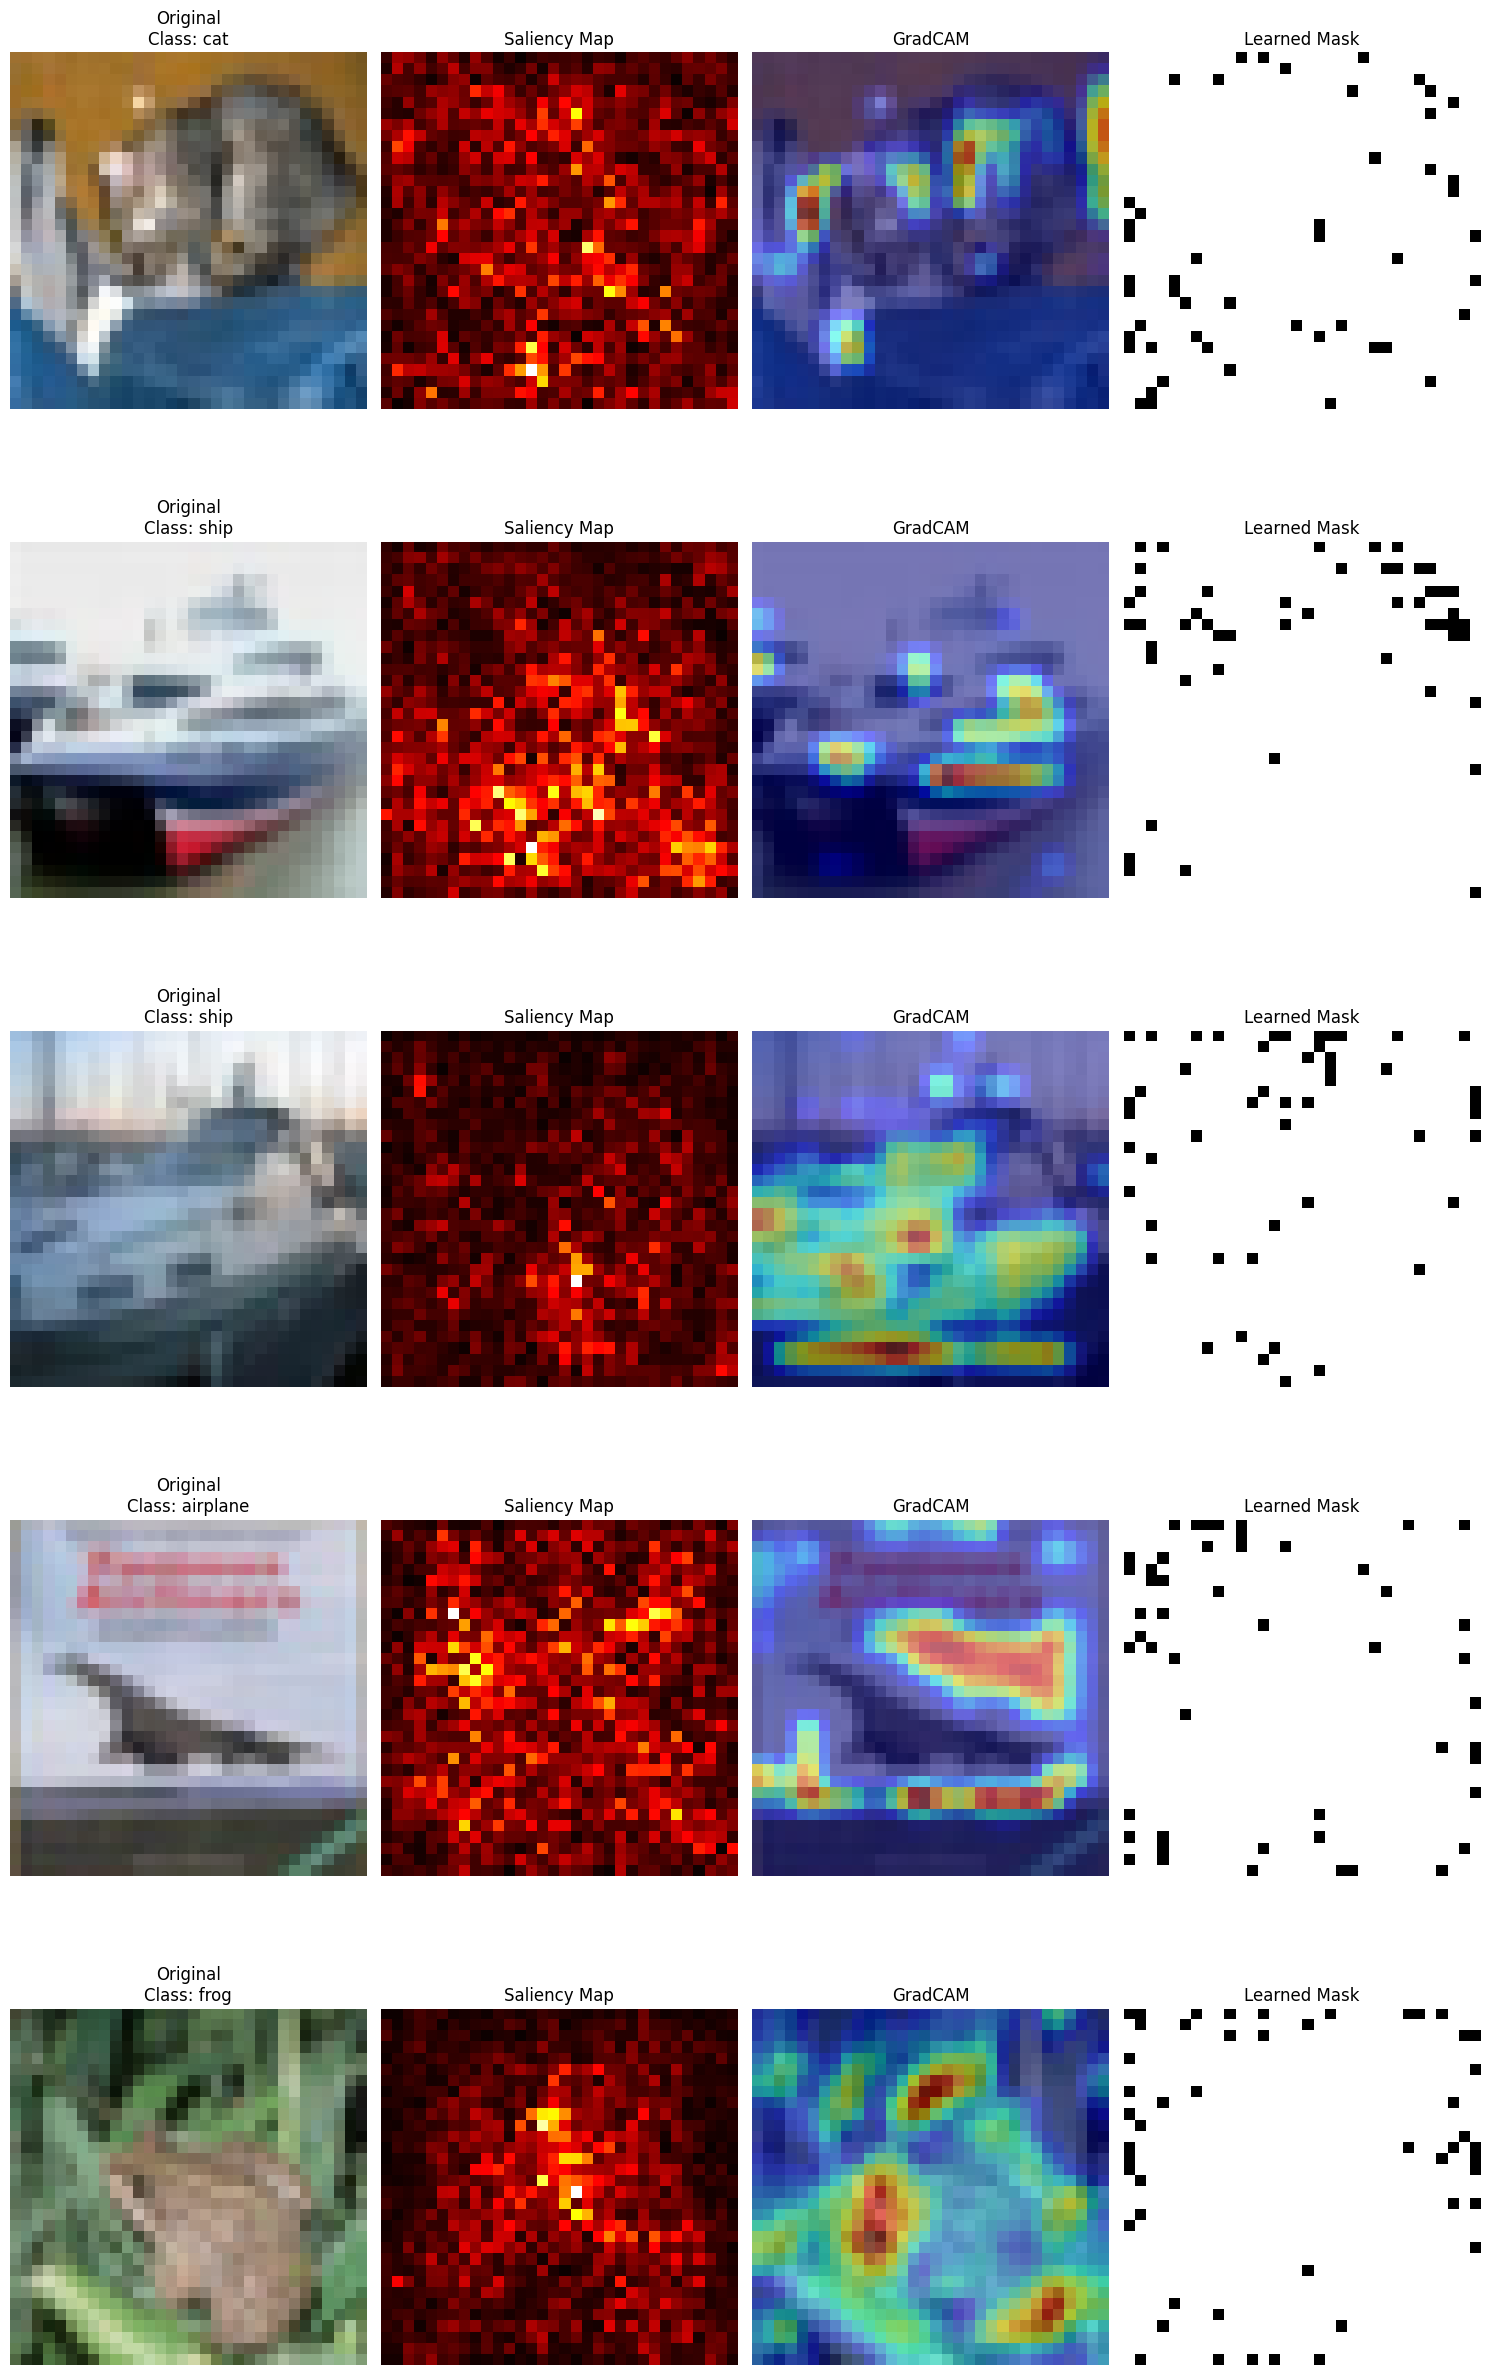

In [25]:
# Visualization
print('\nVisualizing results...')
for name in models:
    print(f'{name} Saliency:')
    visualize_results(models[name], device, num_images=5)